# Tutorial: Regularization, Model Selection and Evaluation

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/git/https%3A%2F%2Fgitlab.in2p3.fr%2Fenergy4climate%2Fpublic%2Feducation%2Fmachine_learning_for_climate_and_energy/master?filepath=book%2Fnotebooks%2F04_tutorial_regularization_selection_evaluation.ipynb)

Tutorial to the class [Regularization, Model Selection and Evaluation](05_regularization_selection_evaluation.ipynb).

<div class="alert alert-block alert-info">
    <b>Tutorial Objectives</b>
    
- Apply regularization methods: Ridge and Lasso
- Compute and plot validation curves
- Compare $k$-nearest neighbors to Ridge/Lasso
</div>

## Scientific objective

To predict the France average wind capacity factor from the geopotential height at 500hPa over the Euro-Atlantic sector.

## Dataset presentation

- Input:
  - [Geopotential height](https://en.wikipedia.org/wiki/Geopotential_height) at 500hPa
    - Domain: North Atlantic
    - Spatial resolution: $0.5° \times 0.625°$
    - Time resolution: monthly
    - Period: 1980-2021
    - Units: m
    - Source: [MERRA-2 reanalysis](https://gmao.gsfc.nasa.gov/reanalysis/MERRA-2/)
- Target:
  - Onshore wind capacity factors
    - Domain: Metropolitan France
    - Spatial resolution: regional mean
    - Time resolution: daily
    - Period: 2014-2021
    - Units:
    - Source: [RTE](https://opendata.reseaux-energies.fr/)

## Getting ready

### Reading the wind capacity factor data

- Let us follow the same procedure as in [Tutorial: Supervised Learning Problem and Least Squares](02_tutorial_supervised_learning_problem_ols.ipynb) to import the required modules, read the data and select the domain but for the onshore wind capacity factors instead of the electricity demand.
- We also compute monthly averages from the daily data since the we are only interested in predicting the monthly wind capacity factors.

In [1]:
# Path manipulation module
from pathlib import Path
# Numerical analysis module
import numpy as np
# Formatted numerical analysis module
import pandas as pd
# Structured dataset analysis module
import xarray as xr
# Plot module
import matplotlib.pyplot as plt
# Default colors
RC_COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']
# Matplotlib configuration
plt.rc('font', size=14)

# Set data directory
data_dir = Path('data')

# Set keyword arguments for pd.read_csv
kwargs_read_csv = dict(index_col=0, parse_dates=True) 

# Define electricity demand filepath and label
windcf_filename = 'reseaux_energies_capacityfactor_wind-onshore.csv'
windcf_filepath = Path(data_dir, windcf_filename)
windcf_label = 'Wind capacity factor'

# Read windcf data with pandas                                                                                                                                                
df_windcf_daily = pd.read_csv(windcf_filepath, **kwargs_read_csv)

# Select domain
# REGION_NAME = 'Bretagne'
REGION_NAME = 'National'
if REGION_NAME == 'National':
    df_windcf_daily_reg = df_windcf_daily.mean('columns')
    df_windcf_daily_reg.name = REGION_NAME
else:
    df_windcf_daily_reg = df_windcf_daily[REGION_NAME]

# Resample wind capacity factor from daily to monthly means
df_windcf_reg = df_windcf_daily_reg.resample('MS').mean()

### Reading the geopotential height data

- The geopotential height data is in the NetCDF format (structured binary data) and cannot be read as text.
We use the `xarray` module instead to read it.
- We also divide the resolution of the gridded data by a factor 4 in both horizontal dimensions.

In [2]:
# Define temperature filepath and label
START_DATE = '19800101'
END_DATE = '20220101'
z500_filename = 'merra2_analyze_height_500_month_{}-{}.nc'.format(START_DATE, END_DATE)
z500_filepath = Path(data_dir, z500_filename)
z500_label = 'Geopotential height (m)'

# Read geopotential height dataset with xarray                                                                                                                                
ds = xr.load_dataset(z500_filepath)

# Select geopotential height variable                                                                                                                                         
z500_name = 'height_500'                                                                                                                                                     
da_z500_hr = ds[z500_name]

# Downsample geopotential height
N_GRID_AVG = 8
da_z500 = da_z500_hr.coarsen(lat=N_GRID_AVG, boundary='trim').mean().coarsen(                                                                                                 
    lon=N_GRID_AVG, boundary='trim').mean()

> ***Question***
> - Print the geopotential height `DataArray` and make sense of what you read.
> - How many variables constitute the geopotential height field?

In [3]:
# answer cell
# Print the geopotential height
print(da_z500)

# Print the number of variables (grid points)
print('\nNumber of variables: {:d}'.format(np.prod(da_z500.shape[1:])))

<xarray.DataArray 'height_500' (time: 504, lat: 5, lon: 9)>
array([[[9036.447 , 9047.418 , 9036.4   , ..., 9048.905 , 9050.554 ,
         9048.072 ],
        [8284.022 , 8305.854 , 8287.4375, ..., 8237.57  , 8232.705 ,
         8236.674 ],
        [6613.0977, 6593.2896, 6634.099 , ..., 6606.0645, 6598.626 ,
         6640.759 ],
        [4574.955 , 4541.4355, 4583.8027, ..., 4689.7485, 4672.5596,
         4667.0225],
        [2472.706 , 2507.0627, 2560.3286, ..., 2545.6775, 2522.7812,
         2500.9092]],

       [[9043.298 , 9048.771 , 9041.115 , ..., 9042.041 , 9049.766 ,
         9052.319 ],
        [8276.369 , 8284.178 , 8307.613 , ..., 8198.682 , 8233.974 ,
         8256.586 ],
        [6586.577 , 6503.19  , 6602.9043, ..., 6623.228 , 6631.5166,
         6648.6143],
        [4594.674 , 4526.3994, 4546.9717, ..., 4770.912 , 4734.1943,
         4722.115 ],
        [2511.0098, 2494.0972, 2497.2266, ..., 2559.1584, 2545.9722,
...
         9045.58  ],
        [8350.067 , 8360.115 , 834

> ***Question***
> - Compute the mean and the variance of the geopotential height with the `mean` and `var` methods.
> - Plot the mean with the `plot` method.
> - Do a filled-contour plot of the variance with the `plot.contourf` method.

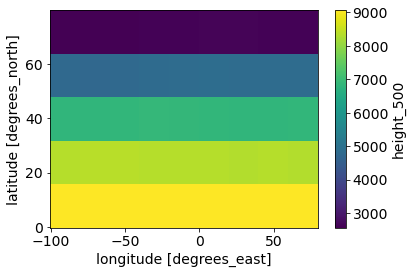

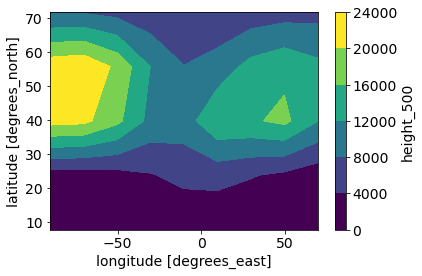

In [4]:
# answer cell
# Compute the mean
da_z500_mean = da_z500.mean('time')

# Plot mean per grid point with pcolormesh
plt.figure()
da_z500_mean.plot()

# Compute the variance
da_z500_var = da_z500.var('time')

# Plot variance per grid point with contourf
plt.figure()
_ = da_z500_var.plot.contourf()

- A strong part of the wind capacity factor signals is the seasonal cycle.
The latter can be estimated from historical data and does not need to be predicted from the geopotential height.
We thus remove it from both the geopotential height and the wind capacity factor.
- We also keep only the dates that are common to both datasets so as to have pairs of feature and target data points used to solve the supervised learning problem.
- Finally, we save the time index and the number of complete years in the dataset for later.

In [5]:
# Remove seasonal cycle from wind capacity factor
da_windcf_reg = df_windcf_reg.to_xarray()                                                                                                                                 
gp_windcf_cycle = da_windcf_reg.groupby('time.month')                                                                                                                     
da_windcf_anom = gp_windcf_cycle - gp_windcf_cycle.mean('time')                                                                                                           
df_windcf_anom = da_windcf_anom.drop('month').to_dataframe()[REGION_NAME]

# Remove seasonal cycle from geopotential height or not
gp_z500_cycle = da_z500.groupby('time.month')                                                                                                                             
da_z500_anom = gp_z500_cycle - gp_z500_cycle.mean('time')

# Convert to bandas with grid points as columns                                                                                                                               
df_z500_anom = da_z500_anom.stack(latlon=('lat', 'lon')).to_dataframe()[
    z500_name].unstack(0).transpose()
    
# Select common index                                                                                                                                                         
idx = df_z500_anom.index.intersection(df_windcf_anom.index)                                                                                                                   
df_z500_anom = df_z500_anom.loc[idx]                                                                                                                                          
df_windcf_anom = df_windcf_anom.loc[idx]                                                                                                                                      
                                                                                                                                                                              
# Number of years in dataset                                                                                                                                                  
time = df_windcf_anom.index                                                                                                                                                   
n_years = time.year.max() - time.year.min() + 1

> ***Question***
> - How many years of common data is there?
> - Plot the time series of the spatially averaged geopotential height and of the national wind capacity factor.
> - Compute the correlation between the spatial average of the geopotential height and the wind capacity factor.

Number of years in dataset: 8


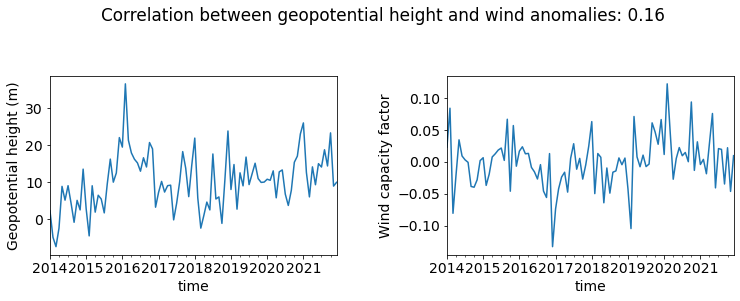

In [6]:
# answer cell
# Print number of years
n_years = time.year.max() - time.year.min() + 1
print('Number of years in dataset:', n_years)

# Get spatial average of geopotential height
df_z500_anom_avg = df_z500_anom.mean('columns')

# Get correlation between geopotential height and wind capacity factor
corr_z500_windcf = np.corrcoef(df_z500_anom_avg, df_windcf_anom)[0, 1]

# Setup figure with 2 panels and sufficient space between them
figsize = np.array(plt.rcParams['figure.figsize']) * np.array([2, 1.2])
fig, ax = plt.subplots(1, 2, figsize=figsize)
fig.tight_layout(pad=5.0)

# Plot geopotential height
df_z500_anom_avg.plot(ax=ax[0])
ax[0].set_ylabel(z500_label)

# Plot wind capacity factor
df_windcf_anom.plot(ax=ax[1])
ax[1].set_ylabel(windcf_label)

# Set title with correlation
_ = fig.suptitle('Correlation between geopotential height and wind anomalies: {:.2f}'.format(
    corr_z500_windcf))

## Regularization

We want to learn to predict the national wind capacity factor from the geopotential height at different grid points using a linear model.

Since the number of input variables, we need to take care of avoiding overfitting.

To do so, we apply different regularization techniques.

### Ridge regression

> ***Question***
> - Apply the ridge regression using `Ridge` from `sklearn.linear_model` to predict the national wind capacity factor from the geopotential height field for an arbitrary regularization parameter value of `10^5`.
> - Plot the histogram estimate of the probability density function of the model coefficients and print the intercept.
> - How does the distribution of the coefficients change when you increase or decrease the regularization coefficient?
> - Explain this behavior based on what you have learned in class.

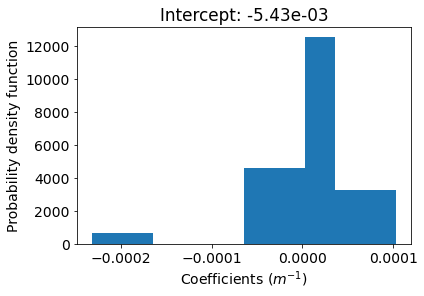

In [7]:
# answer cell
# Import linear_model
from sklearn import linear_model

# Estimator choice
reg_class = linear_model.Ridge

# Prepare input and target
X = df_z500_anom.values
y = df_windcf_anom.values

ALPHA = 1.e5

# Define the Ridge estimator
reg = reg_class(alpha=ALPHA)

# Fit 
reg.fit(X, y)

# Plot coefficients histogram with intercept as title
plt.figure()
plt.hist(reg.coef_, density=True)
plt.xlabel(r'Coefficients ($m^{-1}$)')
plt.ylabel('Probability density function')
_ = plt.title('Intercept: {:.2e}'.format(reg.intercept_))

Answer:

> ***Question***
> - Compute the corresponding validation curves. To do so:
>   - Leave aside a year or more of test data (it will be used later to test the model with regularization).
>   - Compute and plot the train and validation error (using cross-validation) for varying values of the regularization parameter.
> - What is the best value of the regularization parameter according to your estimations?
> - Is there any overfitting and/or underfitting occurring here?

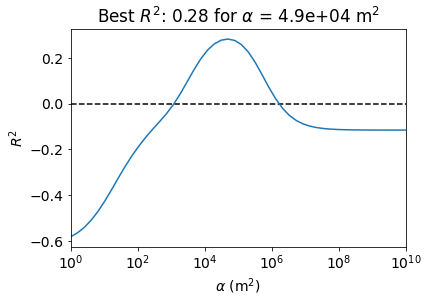

In [8]:
# answer cell
# Import scikit-learn cross-validation function
from sklearn.model_selection import cross_val_score

# Number of test months
N_TEST_YEARS = 2
n_months_per_year = 12
n_test = n_months_per_year * N_TEST_YEARS

# Define array of regularization-parameter values
ALPHA_RNG_RIDGE = np.logspace(0, 10, 50)
complexity_rng = ALPHA_RNG_RIDGE

# Select cross validation data
X_cv = X[:-n_test]
y_cv = y[:-n_test]

# Select test set for later
X_test = X[-n_test:]
y_test = y[-n_test:]

# Set number of splits for cross-validation
n_splits_cv = n_years - n_test // n_months_per_year

# Declare empty arrays in which to store r2 scores and coefficients
r2_validation = np.empty(complexity_rng.shape)
coefs = np.empty((len(complexity_rng), X.shape[1]))

# Loop over regularization-parameter values
for k, complexity in enumerate(complexity_rng):
    # Define the Ridge estimator for particular regularization-parameter value
    reg = reg_class(alpha=complexity)

    # Get r2 test scores from k-fold cross-validation
    r2_validation_arr = cross_val_score(reg, X_cv, y_cv, cv=n_splits_cv)
    
    # Get r2 expected prediction score by averaging over test scores
    r2_validation[k] = r2_validation_arr.mean()
    
    # Save coefficients
    reg.fit(X_cv, y_cv)
    coefs[k] = reg.coef_

# Get the best values of the regularization parameter, prediction R2 and coefficients
i_best = np.argmax(r2_validation)
complexity_best = complexity_rng[i_best]
r2_best = r2_validation[i_best]
coefs_best = coefs[i_best]
    
# Plot validation curve
complexity_label = r'$\alpha$ (m$^2$)'
plt.figure()
plt.plot(complexity_rng, r2_validation)
plt.hlines(0., *complexity_rng[[0, -1]], colors='k', linestyles='--')
plt.xscale('log')
plt.xlabel(complexity_label)
plt.ylabel(r'$R^2$')
_ = plt.title(r'Best $R^2$: {:.2} for $\alpha$ = {:.1e} m$^2$'.format(
    r2_best, complexity_best))
_ = plt.xlim(complexity_rng[[0, -1]])

Answer:

> ***Question***
> - Compare the distribution of the model coefficients for the best value of the regularization parameter to that of the ordinary least squares coefficients.

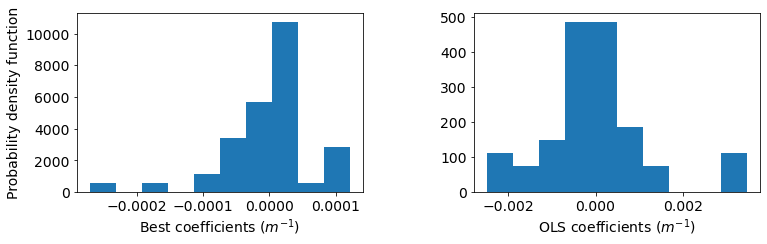

In [9]:
# answer cell
# Setup figure with 2 panels and sufficient space between them
figsize = np.array(plt.rcParams['figure.figsize']) * np.array([2, 1.2])
fig, ax = plt.subplots(1, 2, figsize=figsize)
fig.tight_layout(pad=5.0)

# Plot best coefficients
ax[0].hist(coefs_best, density=True)
ax[0].set_xlabel(r'Best coefficients ($m^{-1}$)')
ax[0].set_ylabel('Probability density function')

# Plot OLS coefficients (approximated by coefficients for minimum value of alpha)
ax[1].hist(coefs[0], density=True)
_ = ax[1].set_xlabel(r'OLS coefficients ($m^{-1}$)')

Answer: 

> ***Question***
> - Give an estimate the prediction error conditioned on some train dataset for the best choice or regularization parameter value.
> - Compare the test value of the score to its validation value.
> - Evaluate and discuss the sensitivity of the test score to the number of test years retained.

In [10]:
# answer cell
# Define the Ridge estimator for best regularization parameter value
reg = reg_class(alpha=complexity_best)

# Fit on train data
reg.fit(X_cv, y_cv)

# Test on test data
r2_test = reg.score(X_test, y_test)

print('Test R2: {:.2f}'.format(r2_test))

Test R2: 0.35


Answer:

> ***Question (optional)***
> - Use nested cross-validation to estimated the expected prediction error for the best choice of regularization parameter value.
> - How does the this value of the test score compare with the one conditionned on a few years of data computed in the previous section? Discuss this result.

In [11]:
# answer cell
from sklearn.model_selection import KFold

# Number of splits for test
n_splits_test = n_years
# Number of splits for cross-validation
n_splits_cv = n_splits_test - 1

# Define k-fold iterator
kf_test = KFold(n_splits=n_splits_test)

# Loop over the train and test indices
r2_test_arr = np.empty((n_splits_test,))
complexity_best_arr = np.empty((n_splits_test,))
for itest, (cv_index, test_index) in enumerate(kf_test.split(X)):
    # Select cross validation data
    X_cv = X[cv_index]
    y_cv = y[cv_index]

    # Select test set for later
    X_test = X[test_index]
    y_test = y[test_index]

    # Declare empty arrays in which to store r2 scores and coefficients
    r2_validation = np.empty(complexity_rng.shape)
    coefs = np.empty((len(complexity_rng), X.shape[1]))

    # Loop over regularization-parameter values
    for k, complexity in enumerate(complexity_rng):
        # Define the Ridge estimator for particular regularization-parameter value
        reg = reg_class(alpha=complexity)

        # Get r2 test scores from k-fold cross-validation
        r2_validation_arr = cross_val_score(reg, X_cv, y_cv, cv=n_splits_cv)

        # Get r2 expected prediction score by averaging over test scores
        r2_validation[k] = r2_validation_arr.mean()

        # Save coefficients
        reg.fit(X_cv, y_cv)
        coefs[k] = reg.coef_

    # Get the best values of the regularization parameter, prediction R2 and coefficients
    k_best = np.argmax(r2_validation)
    complexity_best_arr[itest] = complexity_rng[k_best]

    # Define the Ridge estimator for best regularization parameter value
    reg = reg_class(alpha=complexity_best_arr[itest])

    # Fit on train data
    reg.fit(X_cv, y_cv)

    # Test on test data
    r2_test_arr[itest] = reg.score(X_test, y_test)

# Get mean R2 and regularization coefficient
# (alternative: run the cross-validation on all years to fit the alpha on the entire dataset)
r2_test_mean = r2_test_arr.mean()
r2_test_std = r2_test_arr.std()
complexity_best_mean = complexity_best.mean()
print('Test R2: {:.2f} +/- {:.2f} (1/2 std)'.format(r2_test_mean, r2_test_std / 2))
print('Mean best alpha: {:.2e}'.format(complexity_best_mean))

Test R2: 0.26 +/- 0.12 (1/2 std)
Mean best alpha: 4.94e+04


Answer:

### Lasso regression

> ***Question***
> - Same questions as for the ridge but for the Lasso (using `Lasso` from `sklearn.linear_model`).
> - How do the coefficients evolve compared to the Ridge?

Test R2: 0.31


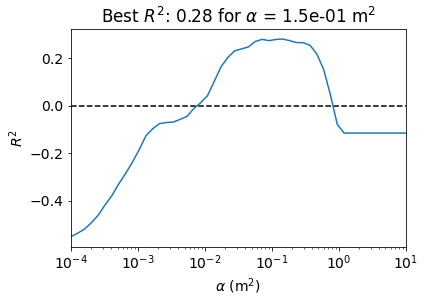

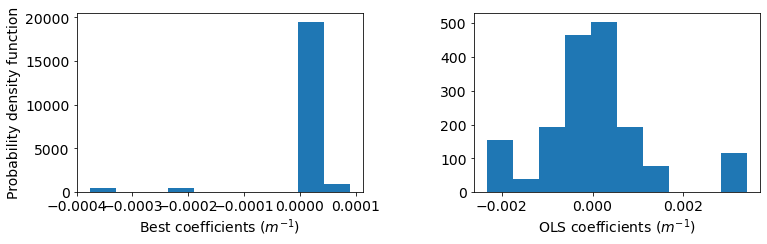

In [12]:
# answer cell
# Estimator choice
reg_class = linear_model.Lasso

# Configure estimator to make sure that fit converges
kwargs_lasso = dict(max_iter=10000)

# Define array of regularization-parameter values
ALPHA_RNG_LASSO = np.logspace(-4, 1, 50)
complexity_rng = ALPHA_RNG_LASSO

# Select cross validation data
X_cv = X[:-n_test]
y_cv = y[:-n_test]

# Select test set for later
X_test = X[-n_test:]
y_test = y[-n_test:]

# Set number of splits for cross-validation
n_splits_cv = n_years - n_test // n_months_per_year

# Declare empty arrays in which to store r2 scores and coefficients
r2_validation = np.empty(complexity_rng.shape)
coefs = np.empty((len(complexity_rng), X.shape[1]))

# Loop over regularization-parameter values
for k, complexity in enumerate(complexity_rng):
    # Define the Ridge estimator for particular regularization-parameter value
    reg = reg_class(alpha=complexity, **kwargs_lasso)

    # Get r2 test scores from k-fold cross-validation
    r2_validation_arr = cross_val_score(reg, X_cv, y_cv, cv=n_splits_cv)
    
    # Get r2 expected prediction score by averaging over test scores
    r2_validation[k] = r2_validation_arr.mean()
    
    # Save coefficients
    reg.fit(X_cv, y_cv)
    coefs[k] = reg.coef_

# Get the best values of the regularization parameter, prediction R2 and coefficients
i_best = np.argmax(r2_validation)
complexity_best = complexity_rng[i_best]
r2_best = r2_validation[i_best]
coefs_best = coefs[i_best]
    
# Plot validation curve
alpha_label = r'$\alpha$ (m$^2$)'
plt.figure()
plt.plot(complexity_rng, r2_validation)
plt.hlines(0., *complexity_rng[[0, -1]], colors='k', linestyles='--')
plt.xscale('log')
plt.xlabel(alpha_label)
plt.ylabel(r'$R^2$')
_ = plt.title(r'Best $R^2$: {:.2} for $\alpha$ = {:.1e} m$^2$'.format(
    r2_best, complexity_best))
_ = plt.xlim(complexity_rng[[0, -1]])

# Setup figure with 2 panels and sufficient space between them
figsize = np.array(plt.rcParams['figure.figsize']) * np.array([2, 1.2])
fig, ax = plt.subplots(1, 2, figsize=figsize)
fig.tight_layout(pad=5.0)

# Plot best coefficients
ax[0].hist(coefs_best, density=True)
ax[0].set_xlabel(r'Best coefficients ($m^{-1}$)')
ax[0].set_ylabel('Probability density function')

# Plot OLS coefficients (approximated by coefficients for minimum value of alpha
ax[1].hist(coefs[0], density=True)
_ = ax[1].set_xlabel(r'OLS coefficients ($m^{-1}$)')

# Define the Ridge estimator for best regularization parameter value
reg = reg_class(alpha=complexity_best, **kwargs_lasso)

# Fit on train data
reg.fit(X_cv, y_cv)

# Test on test data
r2_test = reg.score(X_test, y_test)

print('Test R2: {:.2f}'.format(r2_test))

Answer:

## $K$-nearest neighbor model

> ***Question (optional)***
> - Compute and plot the validation curve for the $k$-nearest neighbor model using `KNeighborsRegressor` from `sklearn.neighbors` for varying number of neighbors.
> - For which value of $k$ is the score best? Represent the best prediction above the scatter plot of the train data.
> - Is there any overfitting occurring?
> - How does the best $k$-nearest neighbor model performs compared to the linear models analyzed so far?

Test R2: 0.07


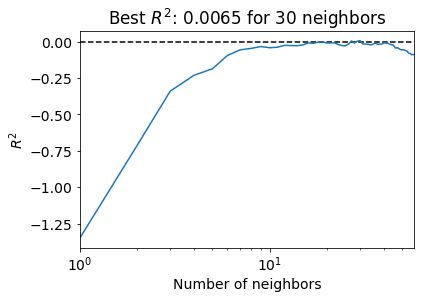

In [13]:
# answer cell
#Import neighbors module from Scikit-Learn
from sklearn import neighbors

# Estimator choice
reg_class = neighbors.KNeighborsRegressor

# Configure estimator
kwargs_nn = dict()

# Liste of n_neighbors
NN_RNG = np.arange(1, 59, 1)
complexity_rng = NN_RNG

# Declare empty array in which to store r2 scores
r2_validation = np.empty(NN_RNG.shape)

# Select cross validation data
X_cv = X[:-n_test]
y_cv = y[:-n_test]

# Select test set for later
X_test = X[-n_test:]
y_test = y[-n_test:]

# Set number of splits for cross-validation
n_splits_cv = n_years - n_test // n_months_per_year

# Declare empty arrays in which to store r2 scores and coefficients
r2_validation = np.empty(complexity_rng.shape)
coefs = np.empty((len(complexity_rng), X.shape[1]))

# Loop over regularization-parameter values
for k, complexity in enumerate(complexity_rng):
    # Define the Ridge estimator for particular regularization-parameter value
    reg = reg_class(n_neighbors=complexity, **kwargs_nn)

    # Get r2 test scores from k-fold cross-validation
    r2_validation_arr = cross_val_score(reg, X_cv, y_cv, cv=n_splits_cv)
    
    # Get r2 expected prediction score by averaging over test scores
    r2_validation[k] = r2_validation_arr.mean()
    
    # Save coefficients
    reg.fit(X_cv, y_cv)

# Get the best values of the regularization parameter, prediction R2 and coefficients
i_best = np.argmax(r2_validation)
complexity_best = complexity_rng[i_best]
r2_best = r2_validation[i_best]
    
# Plot validation curve
complexity_label = 'Number of neighbors'
plt.figure()
plt.plot(complexity_rng, r2_validation)
plt.hlines(0., *complexity_rng[[0, -1]], colors='k', linestyles='--')
plt.xscale('log')
plt.xlabel(complexity_label)
plt.ylabel(r'$R^2$')
_ = plt.title(r'Best $R^2$: {:.2} for {:d} neighbors'.format(
    r2_best, complexity_best))
_ = plt.xlim(complexity_rng[[0, -1]])

# Define the Ridge estimator for best regularization parameter value
reg = reg_class(n_neighbors=complexity_best, **kwargs_nn)

# Fit on train data
reg.fit(X_cv, y_cv)

# Test on test data
r2_test = reg.score(X_test, y_test)

print('Test R2: {:.2f}'.format(r2_test))

Answer:

***
## Credit

[//]: # "This notebook is part of [E4C Interdisciplinary Center - Education](https://gitlab.in2p3.fr/energy4climate/public/education)."
Contributors include Bruno Deremble and Alexis Tantet.
Several slides and images are taken from the very good [Scikit-learn course](https://inria.github.io/scikit-learn-mooc/).

<br>

<div style="display: flex; height: 70px">
    
<img alt="Logo LMD" src="images/logos/logo_lmd.jpg" style="display: inline-block"/>

<img alt="Logo IPSL" src="images/logos/logo_ipsl.png" style="display: inline-block"/>

<img alt="Logo E4C" src="images/logos/logo_e4c_final.png" style="display: inline-block"/>

<img alt="Logo EP" src="images/logos/logo_ep.png" style="display: inline-block"/>

<img alt="Logo SU" src="images/logos/logo_su.png" style="display: inline-block"/>

<img alt="Logo ENS" src="images/logos/logo_ens.jpg" style="display: inline-block"/>

<img alt="Logo CNRS" src="images/logos/logo_cnrs.png" style="display: inline-block"/>
    
</div>

<hr>

<div style="display: flex">
    <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0; margin-right: 10px" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a>
    <br>This work is licensed under a &nbsp; <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.
</div>